### <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS1090A Introduction to Data Science 

## Lab 8: Causal Inference in Practice
**Harvard University**<br>
**Fall 2024**<br>
**Instructors:** Pavlos Protopapas, Natesh Pillai, Chris Gumb<br>

---

In [1]:

#from sklearn.decomposition import PCA
#import scipy as sp
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#from sklearn.preprocessing import PolynomialFeatures, StandardScaler
#from sklearn.model_selection import train_test_split, cross_validate

#from sklearn import datasets

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

from scipy import stats
import statsmodels.api as sm

from matplotlib import pyplot as plt, patches
import seaborn as sns
from IPython.display import display

# Table of Contents

- Yelp A/B Test Data 
- EDA
- Randomization Tests

- UMASS Payroll Data
- Propensity Score Estimation
- Causal Effect Estimation
   

## Yelp A/B Test Data

Our first data set will be based on an experiment that Yelp ran.  Yelp's business model is based on collecting revenue through advertising: they get paid everytime a user clicks on this advertisement (and the amount of money is not always the same).  

They were interested in determining if there was a better way to present advertising to their users, and so they designed an A/B test.  When a user is searching through their map feature, *sponsored results*  (i.e., advertisements) are presented to them in one of two ways in this experiment (randomly assigned, and users were *blinded*): 
  
+ **Treatment A** (the standard, `control` version) presented sponsored results that do **not** respect map search geographical constraints (depicted to the left below).
+ **Treatment B** (the new `treatment` version) presented sponsored results that do respect map search geographical constraints (depicted to the right below).

Our goal is to determine whether the new way of presenting ads (honoring geographical constraints) improves their advertising revenue.

$^*$Note: this just one way a user can interact with Yelp.  Most users do not use the map feature.


<img src='fig/yelp_abtest.png' width='1000px'>

The data set contains several variables:

+ `treatment`: A categorical variable indicating whether the observation was in the treatment or control group (`treatment`/`control`).  
+ `desktop`: A categorical variable indicating whether the user accessed the desktop or mobile platform (`desktop`/`mobile`). 
+ `desktop_binary`: A binary variable indicating whether the user accessed the desktop platform. 
+ `local_service`: A categorical variable taking a value `local` if the search was for a local service like plumbing, moving, or construction OR `non-local` if the search was for anything else, like a restaurant, bar, or shop; or  (`non-local`/`local`).
+ `local_binary`: A binary variable indicating whether the search was for a local service 
+ `eligible`: A categorical variable indicating whether the search was eligible to be shown an advertisement (`eligible`/`not eligible`). For example, Yelp doesn't show advertisements on some sensative searches, such as "hospital."
+ `eligible_binary`: A binary variable indicating whether the search was eligible to be shown an advertisement.
+  `ad_shown`: A categorical variable indicating whether an advertisement was shown (`shown`/`not shown`).
+  `ad_shown_binary`: A binary variable indicating whether an advertisement was shown. 
+  `ad_click`: A categorical variable indicating whether a shown advertisement was clicked (`clicked`/`not clicked`). Note that this variable is `not clicked` whenever an advertisement is `not shown`.
+  `ad_click_binary`: A binary variable indicating whether a shown advertisement was clicked. 
+  `revenue`: The revenue collected from the search. Yelp only receives a payment if the advertisement is clicked.
+  `date`: The date when the user accessed Yelp.
+  `weekend`: A binary indicator whether the date fell over the weekend (Saturday or Sunday).
+  `day_number`: The day of the study (day of the month within January).

We read in the data below.

In [3]:
yelp = pd.read_csv('data/yelp_df.csv')
yelp.head()

,treatment,desktop,desktop_binary,local_service,local_binary,eligible,eligible_binary,ad_shown,ad_shown_binary,ad_click,ad_click_binary,revenue,date,weekend,day_number
0,control,mobile,0,non-local,0,eligible,1,shown,1,clicked,1,1.41,1/1/19,0,1
1,control,mobile,0,non-local,0,eligible,1,shown,1,not clicked,0,0.00,1/1/19,0,1
2,control,mobile,0,local,1,eligible,1,shown,1,not clicked,0,0.00,1/1/19,0,1
3,control,mobile,0,local,1,eligible,1,shown,1,clicked,1,5.57,1/1/19,0,1
4,treatment,mobile,0,non-local,0,eligible,1,shown,1,clicked,1,1.29,1/1/19,0,1


## **Exploratory Data Analysis**


#### Step 1: Visuals and Summaries

We may want to explore some of the following:
*   The proportion of local vs. non-local searches and desktop vs. mobile searches.
*   The proportion of eligible vs. not eligible searches, ads shown vs. no ads shown, and clicked vs. not clicked.
*   Revenue (compute the sum and mean), then plot a histogram. What is the interpretation of the mean revenue?
*   Does revenue differ across local/non-local searches? What about mobile/desktop? Why did some searches not generate any revenue? What if you filter out rows that generate 0 revenue?
*   ...or other relationship you may be interested in.

**Hint:** Try using a boxplot to visualize how revenue differs across the two types of searches (treatments), and a barplot to visualize how *click-through rate* differs across the two types of searches (treatments).


In [4]:
# Example: basic counts, and a sanity check via a hypothesis test
print(yelp['treatment'].value_counts())

display(pd.crosstab(yelp['treatment'],yelp['desktop']))

# Check for independence of treatment and desktop in determining crosstab values
chi2test = stats.chi2_contingency(pd.crosstab(yelp['treatment'],yelp['desktop']))
print("Chi-sq stat =",chi2test[0],"pvalue =",chi2test[1])


#chi2test = ("statistic", "pvalue", "dof", "expected_freq") 

treatment
treatment    87635
control      87365
Name: count, dtype: int64


desktop,desktop,mobile
treatment,,
control,26111,61254
treatment,26099,61536


Chi-sq stat = 0.22880393197966964 pvalue = 0.6324121165097836


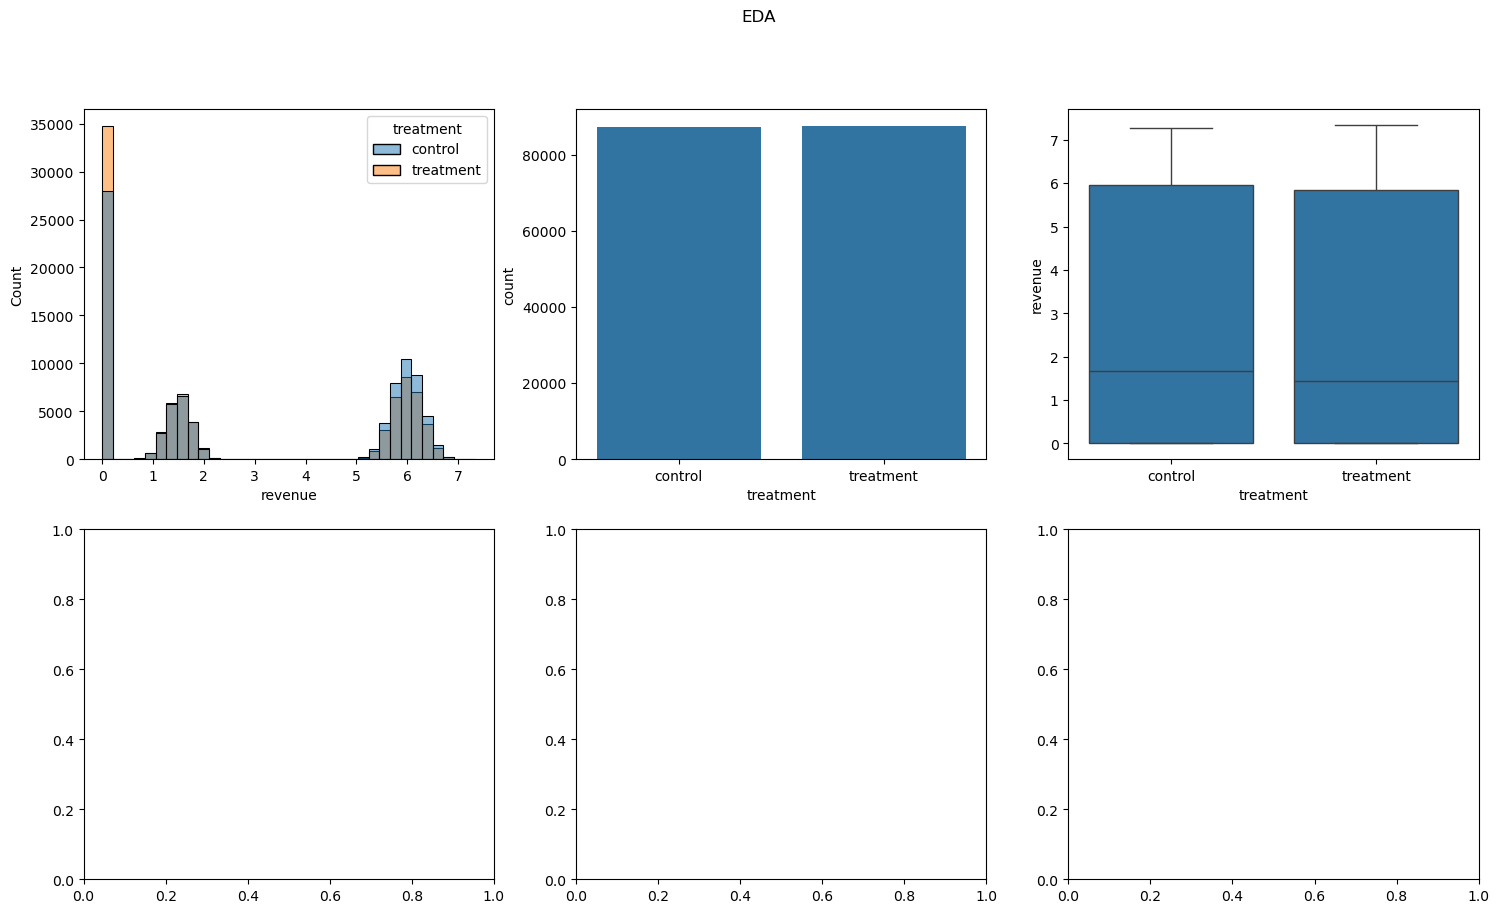

In [5]:
###############
# Your code here:
# We get you started
###############

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

sns.histplot(yelp, x='revenue', hue='treatment', ax=axs[0])
# axs[0,0].set_xlabel('revenue')
sns.countplot(data=yelp,x='treatment',ax=axs[1])
sns.boxplot(data=yelp,y='revenue',x='treatment',ax=axs[2])


fig.suptitle('EDA');


#### Question 1.2: **Conduct hypothesis tests**

We want to compare the proportion of eligible ads in the control group to the proportion in the treatment group. Generally, when comparing proportions, we use a proportions test with the `stats.chi2_contingency()` function. However, because of the large sample size, the t-test gives approximately the same results as a proportions test. Therefore, you can compare `Eligible` across the two groups using either the `stats.ttest_ind` function or `stats.chi2_contingency`.

In [6]:
################
# your code here
################

#### Question 1.3: **Interpret results**

What can you conclude based on the EDA and hypothesis test?  What do these results mean to the company?

*Your answer here* 

## Assessing Treatment Effect

Below we provide you the code to run a randomization test (and the related two-sample t-test) to determine whether the click-through rate is different in the two treatments.  Your task is to 
+ (1) interpret the results and 
+ (2) perform a randomization test for revenue.

In [7]:
#Testing to see if click-through rate is different in the 2 groups

y = yelp['ad_click_binary']
x = pd.Series(1*(yelp['treatment']=='treatment'))

obs_diff = np.mean(y[x==1]) - np.mean(y[x==0])
print("The estimated diff in click-through rate is:", obs_diff)



The estimated diff in click-through rate is: -0.0763454610802976


In [8]:
# randomization/permutation test for click-through-rate
np.random.seed(109)
nsims = 1000
perm_diffs = []

for i in np.arange(nsims):
    x_perm = np.random.permutation(x)
    perm_diffs.append(np.mean(y[x_perm==1]) - np.mean(y[x_perm==0]))

p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
p_value

np.float64(0.0)

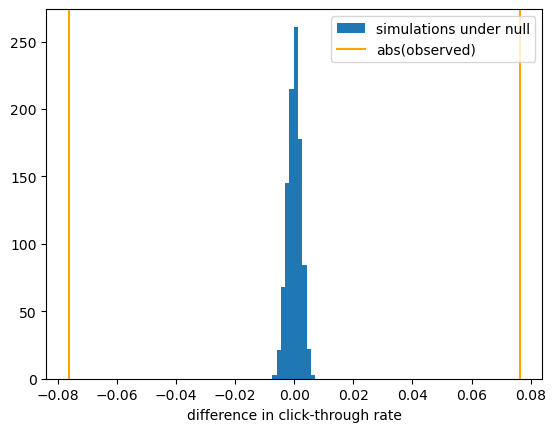

In [9]:
plt.hist(perm_diffs, label="simulations under null")
plt.axvline(obs_diff,c="orange", label="abs(observed)")
plt.axvline(-obs_diff,c="orange");
plt.xlabel("difference in click-through rate")
plt.legend();

#### Question 2.1: Interpret the results

Which group has a higher click-through rate?  Is this difference statistically significant?  What is the p-value for the randomization test?  Why is it so small?  What does this mean for the company?

*your answer here*

#### Question 2.2: Perform a Randomization Test

Perform a randomization test to see if revenue if different in the 2 treatment groups.

Which group has a higher click-through rate?  Is this difference statistically significant?  What is the p-value for the randomization test?  Why is it so small?

*Hint:* `np.random.permutation()` can be useful here. 

In [10]:
################
# your code here
# Test to see if revenue is different in the 2 groups
################



#### Question 2.3: Interpret the results

Which group had a higher mean revenue?  Is this difference statistically significant?  What is the p-value for the randomization test?  What does this mean for the company?

*Your answer here*

## UMASS Payroll Data

Data were collected from the publicly available payroll data for employees of UMASS.  The variables in the data set `UMASS_payroll_2018.csv` include:

+ `year`: 2018 for everyone
+ `sex`: whether the employee self-identifies as `male` or `female`
+ `position_title`: the employee's position at the University
+ `position_type`: `Full Time Employee` for everyone (`Part Time Employee`s were filtered out).  
+ `service_end_date`: the date of last employment in the year (Dec 22 is when the fiscal year ended).  This could be used to filter out those that left before the year ended
+ `days_employed`: how many days of 2018 was the pay based off of
+ `pay_total`: total amount of pay received, in US dollars
+ `annual_rate`: the contracted salary signed, in US dollars
+ `location`: the campus of the employees' primary appointment
+ `contract`: which type of employee is it based on contract type/group 
+ `bargaining_group_num`: a key/id for the contract type/group
+ `bargaining_group_title`: the title of the contract type/group

Use this dataset to assess the *causal effect* of `sex` on `pay`.  Note: we can not randomize `sex`, but we can still estimate a quasi-causal effect as to whether `sex` is a determinant of differences in `pay_total`.

In [11]:
umass = pd.read_csv('data/UMASS_Payroll_2018.csv')

umass['log2pay'] = np.log2(umass['pay_total'])
umass['female'] = 1*(umass['sex'] == 'female')

umass.head()

,year,sex,position_title,position_type,service_end_date,days_employed,pay_total,annual_rate,location,contract,bargaining_group_num,bargaining_group_title,log2pay,female
0,2018,male,Plumber & Steamfitter I,Full Time Employee,1/6/18 0:00,15,68.91,52520.520,U Mass Dartmouth,AFT Massachusetts Maintainers (D83),D83,AFT Massachusetts Maintainers,6.106641,0
1,2018,male,Director Counseling Center,Full Time Employee,1/6/18 0:00,15,114.56,100000.004,U Mass Dartmouth,ESU Professional Local 1895 (D85),D85,ESU Professional Local 1895,6.839960,0
2,2018,male,Skilled Laborer I,Full Time Employee,12/8/18 0:00,351,162.40,46628.660,U Mass Amherst,AFSCME Local 1776 (A01),A01,AFSCME Local 1776,7.343408,0
3,2018,female,Administrative Assistant I,Full Time Employee,12/8/18 0:00,351,176.04,61119.748,U Mass Dartmouth,AFSCME Local 507 (D82),D82,AFSCME Local 507,7.459759,1
4,2018,female,Librarian I,Full Time Employee,12/8/18 0:00,351,203.76,64989.600,U Mass Amherst,MTA/NEA USA Classified (A08),A08,MTA/NEA USA Classified,7.670727,1


#### Question 3.1: EDA

Explore the following (visually and numerically):
*   The difference in pay for males and females.
*   Any differences in pay across locations
*   Any differences in the distribution of sexes across 'location'
*   Any differences in pay across 'bargaining_group_title'
*   Any differences in the distribution of sexes across 'bargaining_group_title'

$^*$Note: you may want to consider using `log2pay` instead of `paytotal` throught this problem.  Why?

In [12]:
# Here are univariate summaries to get you started

print(umass['sex'].value_counts())
print(umass['position_title'].nunique())
print(umass['location'].value_counts())
print(umass['bargaining_group_title'].value_counts())


umass[['pay_total','days_employed','log2pay']].describe()

sex
female    2489
male      2355
Name: count, dtype: int64
1659
location
U Mass Amherst                 1798
U Mass Worcester               1390
U Mass Lowell                   581
U Mass Boston                   568
U Mass Dartmouth                372
U Mass Central Office           124
U Mass Other Administrative      11
Name: count, dtype: int64
bargaining_group_title
Non-Unit Professional             1264
MTA/NEA Professional Staff         627
MTA/NEA MSP Faculty                406
AFSCME Local 1776                  363
MTA/NEA USA Classified             342
Residents/Post Docs                302
SEIU Professional                  207
MSP/FSU Faculty & Librarian        190
MTA/NEA  MSP/UML Faculty           164
Non-Unit Classified                144
AFT Faculty Federation             122
SHARE                              110
ESU Professional Local 1895         95
MTA/NEA Classified                  77
AFSCME Trades and Building Svc      71
MTA/NEA Maintenance/Trades          57
A

,pay_total,days_employed,log2pay
count,4.844000e+03,4844.000000,4844.000000
mean,7.199939e+04,352.390173,15.730581
std,5.266442e+04,50.464983,1.299709
min,6.891000e+01,15.000000,6.106641
25%,4.062088e+04,365.000000,15.309934
50%,6.153951e+04,365.000000,15.909225
75%,9.206670e+04,365.000000,16.490392
max,1.069752e+06,365.000000,20.028845


In [13]:
################
# your code here
################

#### Question 3.2: Estimate Propensity Scores of `sex`

Below we provide the code to estimate the 

In [14]:
################
# fit a logistic regression model to estimate the 
# probability of being female based on the predictors
# `location`,`bargaining_group_title`, and `days_employed`
# save these probabilities as `propensity_scores`
################

# create dummies, don't forget to set 'drop_first=True'.
# drop any dummies that have fewer than 20 observations in them
dummies = pd.get_dummies(umass[['location','bargaining_group_title']] ,drop_first=True)

# create X
X = pd.concat([umass[['days_employed']],dummies],
              axis=1)
X = X[X.columns[np.sum(np.abs(X))>=20]]

# fit model and print out the coefficients
# YOUR CODE HERE
logit = LogisticRegressionCV(Cs=np.logspace(-2.2,10),
                             max_iter=1000,
                             fit_intercept=True).fit(X,umass['female'])
coefs = pd.DataFrame({'variable': X.columns , 'coef': logit.coef_[0]})

# define `propensity scores`
propensity_scores = logit.predict_proba(X)[:,1]
umass['propensity_scores'] = propensity_scores

/home/chris/teaching/2024-CS1090A-private/.mamba/envs/cs109a/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


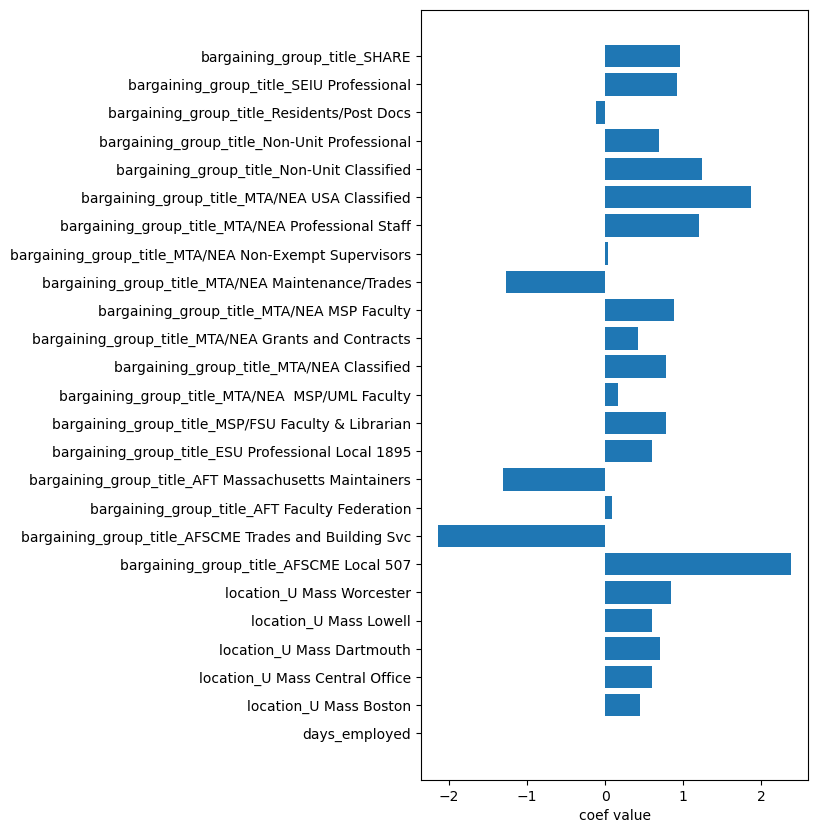

In [15]:
plt.figure(figsize=(5, 10))
plt.barh(y=coefs['variable'],width=coefs['coef'],);
plt.xlabel("coef value");

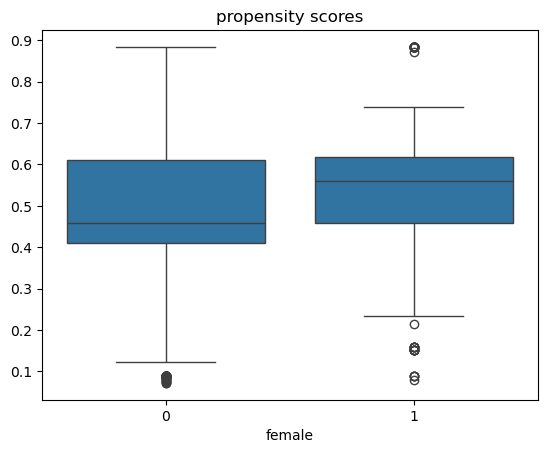

In [16]:
ax = sns.boxplot(y=propensity_scores,x=umass['female']);
ax.set_title("propensity scores");

#### Question 3.3: Interpret the results

* What factors are most related to the probability of being female?
* What may be wrong with using this simple logistic regression model with `C=0.03` to estimate propensity scores?  What should be done instead?


*your answer here*

#### Question 3.4: Estimate the causal effect of `sex`

Fit several models to estimate the relationship between `log2pay` and whether or not an employee is `female`.

In [17]:
################
# fit several linear regression models to predict `pay_total`:
# 1. `female` alone
# 2. `female`,`location`,`bargaining_group_title`, and `days_employed`
# 3. `female` and `propensity_scores`
# 4. `female` alone, but using `propensity_scores` as the 'sample_weight'
################

# Model1. Baseline model - no control for confounding
lm1 = LinearRegression(fit_intercept=True).fit(umass[['female']],umass['log2pay'])
print(lm1.coef_[0])

X = pd.concat([umass[['female','days_employed']],dummies],
              axis=1)

# Model 2. Traditional covariate adjustment
lm2 = LinearRegression(fit_intercept=True).fit(X,umass['log2pay'])
print(lm2.coef_[0])

# Model 3. Propensity score as a covariate
X = pd.concat([umass[['female']],pd.Series(propensity_scores)],
              axis=1)
X.columns = X.columns.astype(str) # to avoid error in lm3

lm3 = LinearRegression(fit_intercept=True).fit(X,umass['log2pay'])
print(lm3.coef_[0])

# Model 4. Inverse probability weighting (IPW)
#X = pd.concat([umass[['female']],pd.Series(propensity_scores)],
#              axis=1)
lm4 = LinearRegression(fit_intercept=True).fit(umass[['female']],umass['log2pay'],sample_weight=propensity_scores)
print(lm4.coef_[0])



-0.21175433340303285
-0.25970178198415933
-0.25089750523901017
-0.2846870239112795


#### Question 3.5: Using propensity scores for matching

Create 2 subsets of data:

1) `umass_restricted` which removes any females with propensity scores above np.max(propensity_scores[umass['female']==0]) and any males with propensity scores above np.min(propensity_scores[umass['female']==1]).

2) `umass_matched` which, for every female, finds the closest matching male based on tehir propensity score.

Use these subsets of data to estimate the adjusted difference in `log2pay` and `pay_total` comparing females to males (you can simply fit 2 linear regression models to predict `log2pay` from `female`).

In [18]:
##############
# create the umass_restricted data frame
##############

max_males = np.max(propensity_scores[umass['female']==0])
min_females = np.min(propensity_scores[umass['female']==1])


print(max_males, min_females)

which_males = (umass['propensity_scores']>=min_females) & (umass['female']==0)
which_females = (umass['propensity_scores']<=max_males) & (umass['female']==1)
print((sum(which_males),sum(which_females)))

umass_restricted = umass[which_males | which_females]

0.8835706587949482 0.07905220208959751
(2350, 2489)


In [19]:
##############
# estimate the causal effect
##############


lm_restricted = LinearRegression(fit_intercept=True).fit(umass_restricted[['female']],
                                                         umass_restricted['log2pay'])
print(lm_restricted.coef_[0])


-0.21989833738594491


In [20]:
##############
# we create the umass_matched data frame for you
##############
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

umass['id'] = umass.index
X = pd.concat([umass[['days_employed','id','female']],dummies],
              axis=1)
X = X[X.columns[np.sum(np.abs(X))>=20]]

psm = PsmPy(X, treatment='female', indx='id', exclude = [])

/home/chris/teaching/2024-CS1090A-private/.mamba/envs/cs109a/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [21]:
psm.logistic_ps(balance = False)
psm.knn_matched(matcher='propensity_score', replacement=True, 
                caliper=None, drop_unmatched=True)

# To get means from matched data:
female_pay = umass.loc[psm.df_matched[psm.df_matched['female']==1]['id'].values]['pay_total']
male_pay = umass.loc[psm.df_matched[psm.df_matched['female']==0]['id'].values]['pay_total']
print(female_pay.mean() - male_pay.mean())

-25624.298080679408


In [22]:
# ##############
# # we create the umass_matched data frame for you
# ##############

# from psmpy import PsmPy
# from psmpy.functions import cohenD
# from psmpy.plotting import *

# umass['id']=umass.index
# X = pd.concat([umass[['days_employed','id','female']],dummies],
#               axis=1)
# X = X[X.columns[np.sum(np.abs(X))>=20]]

# psm = PsmPy(X, treatment='female', indx='id', exclude = [])

In [23]:
# psm.logistic_ps(balance = False)
# psm.knn_matched(matcher='propensity_score', replacement=True, 
#                 caliper=None, drop_unmatched=True)

# psm.df_matched.head()

# np.mean(umass.loc[[psm.df_matched['id'][psm.df_matched['female']==1]]])

In [24]:
##############
# Yor code here 
# use umass_matched data frame to estimate the causal effect
##############

female_pay = umass['pay_total'].iloc[psm.df_matched['id'][psm.df_matched['female']==1]]
male_pay = umass['pay_total'].iloc[psm.df_matched['id'][psm.df_matched['female']==0]]
np.mean(female_pay) - np.mean(male_pay)

np.float64(-25624.298080679408)

#### Question 3.6: Interpret the results

What do these results say about whether females get paid less in the UMASS system?  Did the causal approach adjust the estimate much?  Why would this be the case?


*your answer here*

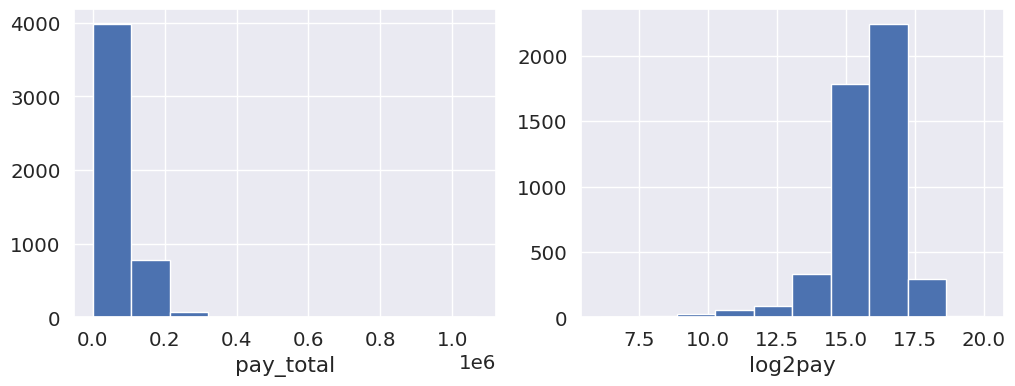

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axs[0].hist(umass['pay_total'])
axs[0].set_xlabel('pay_total');
axs[1].hist(umass['log2pay'])
axs[1].set_xlabel('log2pay');
